# Bayesian SDT w/ PyMC3

In this notebook, I will try to reproduce [Bayesian signal detection theory](https://mvuorre.github.io/posts/2017-10-09-bayesian-estimation-of-signal-detection-theory-models/). The main purpose is not to re-invent the wheel, but to learn how point-wise log-likelihood is calculated when the observation is not equal.

The data is from [Wright 2011a](https://github.com/cran/sdtalt)



In [57]:
import pymc3 as pm
import arviz as az
import xarray as xr
import pandas as pd
import numpy as np

In [7]:
confcontr = pd.read_csv (r'confcontr.csv')
confcontr.head()

subno  sayold  isold
0     53       1      0
1     53       1      1
2     53       1      1
3     53       1      1
4     53       1      0

In [44]:
sdt = confcontr.copy()
sdt['type'] = 'hit'
sdt['type'][(sdt['isold'] == 1) & (sdt['sayold'] == 0)] = 'miss'
sdt['type'][(sdt['isold'] == 0) & (sdt['sayold'] == 0)] = 'cr'
sdt['type'][(sdt['isold'] == 0) & (sdt['sayold'] == 1)] = 'fa'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [9]:
sdt

subno  sayold  isold type
0        53       1      0   fa
1        53       1      1  hit
2        53       1      1  hit
3        53       1      1  hit
4        53       1      0   fa
...     ...     ...    ...  ...
3095     83       1      1  hit
3096     83       0      0   cr
3097     83       0      0   cr
3098     83       1      1  hit
3099     83       0      0   cr

[3100 rows x 4 columns]

In [45]:
sdt = sdt.groupby(['subno', 'type']).size().to_frame().reset_index()
sdt = sdt.rename(columns={0:"value"})
sdt = sdt.pivot(index = 'subno', columns='type', values = 'value')
sdt

type   cr  fa  hit  miss
subno                   
53     33  20   25    22
54     39  14   28    19
55     36  17   31    16
56     43  10   38     9
57     35  18   29    18
58     41  12   30    17
59     46   7   21    26
60     38  15   33    14
61     42  11   25    22
62     45   8   22    25
63     38  15   36    11
64     47   6   40     7
65     39  14   26    21
66     28  25   40     7
67     33  20   27    20
68     47   6   44     3
69     32  21   35    12
70     40  13   32    15
71     36  17   26    21
72     31  22   32    15
73     40  13   31    16
74     43  10   36    11
75     47   6   28    19
76     36  17   34    13
77     42  11   31    16
78     36  17   22    25
79     35  18   33    14
80     49   4   26    21
81     36  17   32    15
82     41  12   27    20
83     40  13   25    22

In [46]:
from scipy.stats import norm
sdt['zhr'] = norm.ppf(sdt['hit'] / (sdt['hit'] + sdt['miss']))
sdt['zfa'] = norm.ppf(sdt['fa'] / (sdt['fa'] + sdt['cr']))
sdt['dprime'] = sdt['zhr'] - sdt['zfa']
sdt['crit'] = - sdt['zfa']
sdt

type   cr  fa  hit  miss       zhr       zfa    dprime      crit
subno                                                           
53     33  20   25    22  0.080084 -0.312426  0.392510  0.312426
54     39  14   28    19  0.242348 -0.630600  0.872948  0.630600
55     36  17   31    16  0.411302 -0.465589  0.876891  0.465589
56     43  10   38     9  0.872421 -0.882774  1.755195  0.882774
57     35  18   29    18  0.297667 -0.413493  0.711160  0.413493
58     41  12   30    17  0.353913 -0.750705  1.104618  0.750705
59     46   7   21    26 -0.133729 -1.116634  0.982905  1.116634
60     38  15   33    14  0.530530 -0.573897  1.104426  0.573897
61     42  11   25    22  0.080084 -0.814962  0.895046  0.814962
62     45   8   22    25 -0.080084 -1.032396  0.952311  1.032396
63     38  15   36    11  0.725598 -0.573897  1.299495  0.573897
64     47   6   40     7  1.041007 -1.209645  2.250652  1.209645
65     39  14   26    21  0.133729 -0.630600  0.764329  0.630600
66     28  25   40     7  1.041007 -0.071002  1.112009  0.071002
67     33  20   27    20  0.187761 -0.312426  0.500187  0.312426
68     47   6   44     3  1.523396 -1.209645  2.733041  1.209645
69     32  21   35    12  0.657844 -0.263127  0.920971  0.263127
70     40  13   32    15  0.470080 -0.689409  1.159489  0.689409
71     36  17   26    21  0.133729 -0.465589  0.599318  0.465589
72     31  22   32    15  0.470080 -0.214460  0.684540  0.214460
73     40  13   31    16  0.411302 -0.689409  1.100711  0.689409
74     43  10   36    11  0.725598 -0.882774  1.608372  0.882774
75     47   6   28    19  0.242348 -1.209645  1.451993  1.209645
76     36  17   34    13  0.592985 -0.465589  1.058574  0.465589
77     42  11   31    16  0.411302 -0.814962  1.226264  0.814962
78     36  17   22    25 -0.080084 -0.465589  0.385505  0.465589
79     35  18   33    14  0.530530 -0.413493  0.944023  0.413493
80     49   4   26    21  0.133729 -1.436207  1.569936  1.436207
81     36  17   32    15  0.470080 -0.465589  0.935669  0.465589
82     41  12   27    20  0.187761 -0.750705  0.938466  0.750705
83     40  13   25    22  0.080084 -0.689409  0.769493  0.689409

## Estimate EVSDT model with a GLM (one subject)

In `confcontr`, each row(trial) can have one of two responses, "old!" (`sayold` = 1) or "new!)(`sayold` = 0). 

In GLM of binary outcomes, we assume that the outcomes are Bernoulli distributed (Binomial with 1 trial), with prob $p_{i}$ that $y_{i} = 1$.

$$ y_{i} \sim Bernoulli(p_{i})$$

We need to map *p* to a `linear predictor` $\eta$ with a linear regression model. If this link function is probit, we have a "probit GLM":

$$ p_{i} = \Phi(\eta_{i}) $$

$\Phi$ is the cumulative normal density function and map $z$ scores to probabilities. We then model $\eta$ on an intercept and a slope:

$$\eta_{i} = \beta_0 + \beta_1 isold_{i}$$

Therefore, the intercept ($\beta_0$) is the standardized false alarm rate: $c = -zHR = -\beta_0$, and $d' = \beta_1$.

Now we try to model a single subject's data with GLM

In [53]:
data = confcontr[confcontr['subno'] == 53]

data

fml = "sayold ~ 1 + isold"

In [65]:
data.shape

(100, 3)

In [61]:
with pm.Model() as glm_sdt:
#     beta0 = pm.Normal('beta0', mu=0, sd=5)
    
#     beta1 = pm.Normal('beta1', mu=0, sd=5)

    pm.glm.GLM.from_formula(formula=fml, data=data, family=pm.families.Binomial())
    trace = pm.sample(2000, tune = 1000, cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [isold, Intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8923632132526822, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8790059603807479, but should be close to 0.8. Try to increase the number of tuning steps.


In [60]:
?pm.families

Type:        module
String form: <module 'pymc3.glm.families' from '/opt/conda/lib/python3.7/site-packages/pymc3/glm/families.py'>
File:        /opt/conda/lib/python3.7/site-packages/pymc3/glm/families.py
Docstring:   <no docstring>


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d300bbc50>,
      dtype=object)

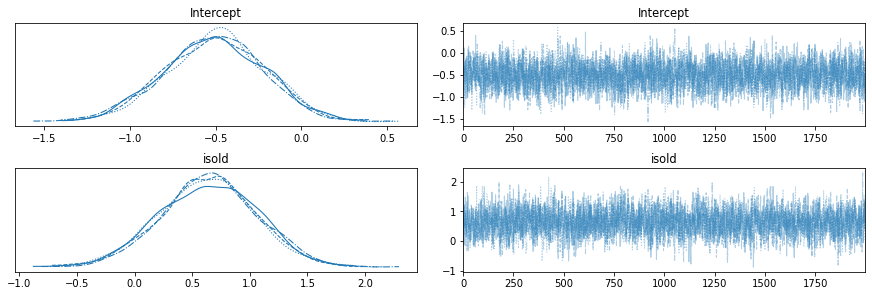

In [62]:
az.plot_trace(trace)

In [63]:
np.exp(az.summary(trace)[["mean", "hdi_3%", "hdi_97%"]])

mean    hdi_3%   hdi_97%
Intercept  0.602300  0.346802  1.018163
isold      1.894585  0.841979  4.022888

In [64]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data